In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic
from cartopy.mpl.geoaxes import GeoAxes
import cmocean.cm as cmo
from IPython.display import HTML
from matplotlib import animation
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import xarray as xr
from xhistogram.xarray import histogram

plt.ioff()

In [2]:
ROOT = Path(".")
DATA_DIR = ROOT / "data"

In [3]:
from_datetime_str = "1994-06-01"
to_datetime_str = "2025-08-01"

In [4]:
traj_errors_ds = xr.open_zarr(DATA_DIR / f"traj_errors_{from_datetime_str}_{to_datetime_str}.zarr")

In [5]:
t0 = traj_errors_ds.reference_time.isel(obs=0).astype("datetime64[s]").astype("datetime64[h]").astype("datetime64[s]")

traj_errors_ds = traj_errors_ds.assign_coords(
    lat=("traj", traj_errors_ds.reference_lat.isel(obs=0).values),
    lon=("traj", traj_errors_ds.reference_lon.isel(obs=0).values),
    month=("traj", t0.dt.month.values),
    horizon=("obs", np.arange(0, np.timedelta64(7, "D") + np.timedelta64(1, "h"), np.timedelta64(1, "h")))
)

traj_errors_ds["reference_time"] = (t0 + traj_errors_ds.horizon).astype("datetime64[s]")  # fix float precision issues

traj_errors_ds = traj_errors_ds.set_coords(
    [
        "reference_time", "reference_lat", "reference_lon",
        "simulated_ensemble_lat", "simulated_ensemble_lon",
        "simulated_mode_lat", "simulated_mode_lon",
        "simulated_mean_lat", "simulated_mean_lon",
    ]
)

traj_errors_ds = traj_errors_ds.set_index(obs="horizon")

In [6]:
traj_errors_ds = traj_errors_ds.sel(obs=slice(np.timedelta64(0, "h"), np.timedelta64(6 * 24, "h")))

In [7]:
versions = ["ensemble", "mode", "mean"]
metrics = ["liu_index", "separation_distance"]
horizons_days = [2, 4, 6]

In [8]:
def add_ensemble_proportions(ds):
    for metric in metrics:
        ens_var = ds[f"ensemble_{metric}"]
        for version in versions[1:]:
            deter_var = ds[f"{version}_{metric}"]

            best_prop = (ens_var < deter_var).mean(dim="sample")
            ds[f"ensemble_best_than_{version}_in_{metric}"] = best_prop
    
    return ds

In [9]:
traj_errors_ds = add_ensemble_proportions(traj_errors_ds)

In [10]:
traj_errors_mean = traj_errors_ds.mean()

In [11]:
traj_errors_mean.load()

<xarray.Dataset> Size: 64B
Dimensions:                                         ()
Data variables:
    ensemble_liu_index                              float32 4B 0.5399
    ensemble_liu_index_crps                         float32 4B 0.4276
    ensemble_separation_distance                    float32 4B 2.621e+04
    ensemble_separation_distance_crps               float32 4B 2.226e+04
    mean_liu_index                                  float32 4B 0.5006
    mean_separation_distance                        float32 4B 2.552e+04
    mode_liu_index                                  float32 4B 0.6454
    mode_separation_distance                        float32 4B 3.438e+04
    ensemble_best_than_mode_in_liu_index            float64 8B 0.6315
    ensemble_best_than_mean_in_liu_index            float64 8B 0.4025
    ensemble_best_than_mode_in_separation_distance  float64 8B 0.65
    ensemble_best_than_mean_in_separation_distance  float64 8B 0.4349

In [12]:
traj_errors_mean_along_time = traj_errors_ds.mean(dim=["traj", "sample"])

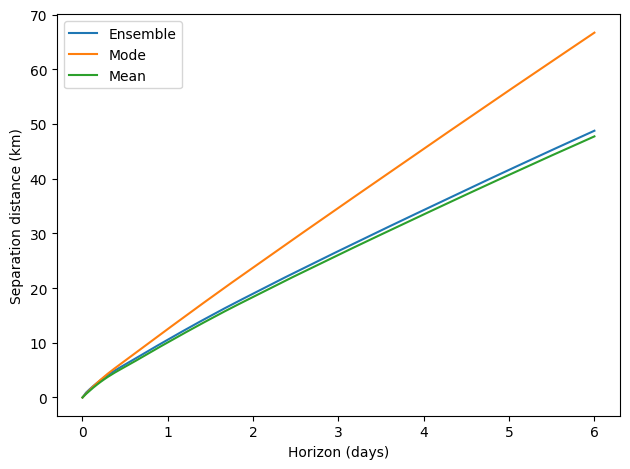

In [13]:
fig, ax = plt.subplots()

(traj_errors_mean_along_time.ensemble_separation_distance * 1e-3).plot(ax=ax, linestyle="-", label="Ensemble")
(traj_errors_mean_along_time.mode_separation_distance * 1e-3).plot(ax=ax, linestyle="-", label="Mode")
(traj_errors_mean_along_time.mean_separation_distance * 1e-3).plot(ax=ax, linestyle="-", label="Mean")

ax.set_xlabel("Horizon (days)")
ax.set_xticks(np.arange(0, 7) * 24 * 3600)
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6])
ax.set_ylabel("Separation distance (km)")
ax.legend()

fig.tight_layout()

plt.show()

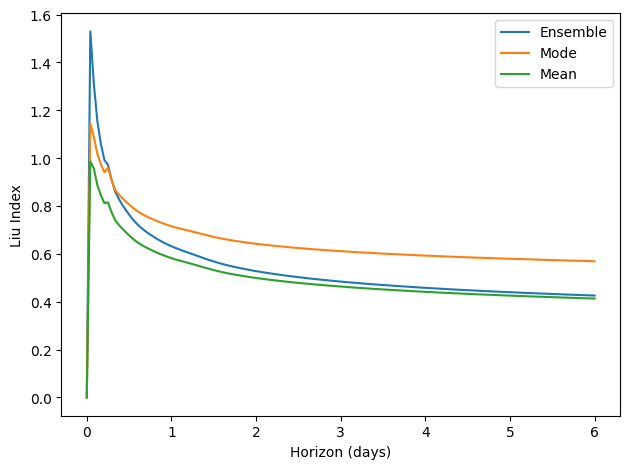

In [14]:
fig, ax = plt.subplots()

traj_errors_mean_along_time.ensemble_liu_index.plot(ax=ax, linestyle="-", label="Ensemble")
traj_errors_mean_along_time.mode_liu_index.plot(ax=ax, linestyle="-", label="Mode")
traj_errors_mean_along_time.mean_liu_index.plot(ax=ax, linestyle="-", label="Mean")

ax.set_xlabel("Horizon (days)")
ax.set_xticks(np.arange(0, 7) * 24 * 3600)
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6])
ax.set_ylabel("Liu Index")
ax.legend()

fig.tight_layout()

plt.show()

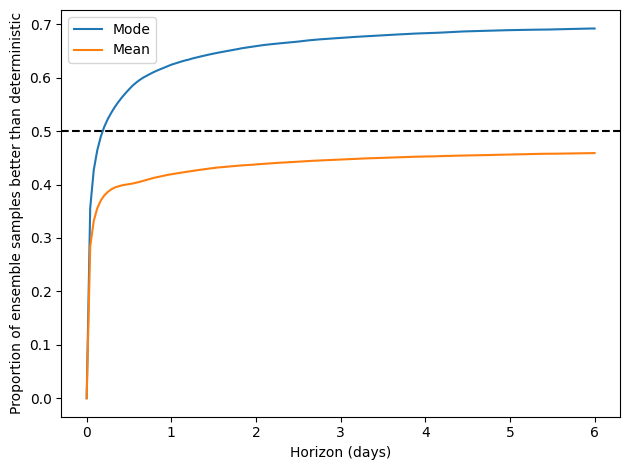

In [15]:
fig, ax = plt.subplots()

traj_errors_mean_along_time.ensemble_best_than_mode_in_separation_distance.plot(ax=ax, linestyle="-", label="Mode")
traj_errors_mean_along_time.ensemble_best_than_mean_in_separation_distance.plot(ax=ax, linestyle="-", label="Mean")

ax.axhline(0.5, color="k", linestyle="--")

ax.set_xlabel("Horizon (days)")
ax.set_xticks(np.arange(0, 7) * 24 * 3600)
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6])
ax.set_ylabel("Proportion of ensemble samples better than deterministic")
ax.legend()

fig.tight_layout()

plt.show()

In [16]:
bin_size = 5  # in degree

lat_bins = np.arange(-90, 91, bin_size)
lon_bins = np.arange(-180, 181, bin_size)
lat_centers = lat_bins[:-1] + bin_size / 2
lon_centers = lon_bins[:-1] + bin_size / 2

month_bins = np.arange(1, 14)
months = np.arange(1, 13)
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [17]:
lat0 = traj_errors_ds.lat
lon0 = traj_errors_ds.lon
m0 = traj_errors_ds.month

In [18]:
histogram_args = {
    "lat_lon_month": (
        (lat_bins, lon_bins, month_bins), {"lat": lat_centers, "lon": lon_centers, "month": months}, (lat0, lon0, m0)
    ),
    "lat_lon": ((lat_bins, lon_bins), {"lat": lat_centers, "lon": lon_centers}, (lat0, lon0)),
    "month": ((month_bins,), {"month": months}, (m0,)),
}

In [19]:
weights_area = np.cos(np.deg2rad(lat0))

In [20]:
def compute_histograms_for_var(ds, varname, horizon_day):
    da = ds[f"{varname}"].sel(obs=np.timedelta64(horizon_day, "D"))

    all_hist_ds = []
    
    for key, (bins, coords, hist_args) in histogram_args.items():
        weighted_count = histogram(*hist_args, bins=bins, weights=xr.ones_like(da) * weights_area)
        weighted_sum_ll = histogram(*hist_args, bins=bins, weights=da * weights_area)
        weighted_sum_ll_sq = histogram(*hist_args, bins=bins, weights=(da ** 2) * weights_area)

        mean = weighted_sum_ll / weighted_count
        std = (weighted_sum_ll_sq / weighted_count - mean ** 2) ** 0.5

        hist_ds = xr.Dataset(
            {
                f"{varname}_{key}_{horizon_day}_mean": (tuple(coords.keys()), mean.data),
                f"{varname}_{key}_{horizon_day}_std": (tuple(coords.keys()), std.data),
            },
            coords=coords
        )
        all_hist_ds.append(hist_ds)
    
    return xr.merge(all_hist_ds)


def compute_histograms(ds):
    all_hist_ds = []

    for varname in ds:
        for horizon_day in horizons_days:
            hist_ds = compute_histograms_for_var(ds, varname, horizon_day)
            all_hist_ds.append(hist_ds)

    return xr.merge(all_hist_ds)

In [21]:
traj_errors_hist_ds = compute_histograms(traj_errors_ds)

In [29]:
FONTSIZE_TITLE = 16
FONTSIZE_LABEL = 14
FONTSIZE_TICK = 12
FONTSIZE_LEGEND = 12


def save_figure(fig, save_path, dpi=300, transparent=False):
    if save_path is not None:
        fig.savefig(
            save_path,
            dpi=dpi,
            bbox_inches="tight",
            pad_inches=0.1,
            transparent=transparent,
            facecolor=fig.get_facecolor() if not transparent else "none",
            edgecolor="none",
        )


def plot_field(da, cmap, vmin, vmax, label, fig=None, ax=None, save_path=None, dpi=300):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.Robinson()})

    im = da.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        add_colorbar=True,
        cbar_kwargs={
            "orientation": "horizontal",
            "pad": 0.025,
            "fraction": 0.05,
            "label": label,
        },
    )

    # Set colorbar font sizes
    cbar = im.colorbar
    cbar.ax.tick_params(labelsize=FONTSIZE_TICK)
    cbar.set_label(label, fontsize=FONTSIZE_LABEL)

    ax.coastlines()
    ax.add_feature(cfeature.LAND, color="lightgrey")

    fig.tight_layout()

    save_figure(fig, save_path, dpi=dpi)

    return fig, ax, im


def plot_annual_movie(da, cmap, vmin, vmax, label, save_path=None, dpi=300, fps=2.5):
    fig, ax, im = plot_field(da.isel(month=0), cmap, vmin, vmax, label)
    title = ax.set_title(month_names[0], fontsize=FONTSIZE_TITLE)

    def update(frame):
        im.set_array(da.isel(month=frame).values.ravel())
        title.set_text(month_names[frame])
        return im, title

    interval = 1000 / fps
    anim = animation.FuncAnimation(fig, update, frames=len(months), interval=interval, blit=True, repeat=True)

    if save_path is not None:
        save_path = Path(save_path)
        if save_path.suffix == ".gif":
            anim.save(save_path, writer="pillow", dpi=dpi, fps=fps)
        else:
            anim.save(save_path, writer="ffmpeg", dpi=dpi, fps=fps, bitrate=2000)

    video = HTML(anim.to_html5_video())

    return fig, anim, video


def plot_annual_mean_field(da, cmap, vmin, vmax, label, title=None, save_path=None, dpi=300):
    fig, ax, _ = plot_field(da, cmap, vmin, vmax, label)
    ax.set_title(title or "Aggregated over the whole period", fontsize=FONTSIZE_TITLE)

    save_figure(fig, save_path, dpi=dpi)

    return fig, ax


def plot_spatial_mean(da, label, save_path=None, dpi=300):
    fig, ax = plt.subplots()

    da.plot(ax=ax, linestyle="-", marker="o")

    ax.set_title("Spatial aggregate", fontsize=FONTSIZE_TITLE)
    
    ax.set_xticks(months)
    ax.set_xticklabels(month_names, fontsize=FONTSIZE_TICK)
    ax.set_xlabel("Month", fontsize=FONTSIZE_LABEL)
    ax.set_ylabel(label, fontsize=FONTSIZE_LABEL)
    ax.tick_params(axis="y", labelsize=FONTSIZE_TICK)

    fig.tight_layout()

    save_figure(fig, save_path, dpi=dpi)

    return fig, ax

/home/bertrava/.conda/envs/calibration/lib/python3.11/site-packages/dask/_task_spec.py:768: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


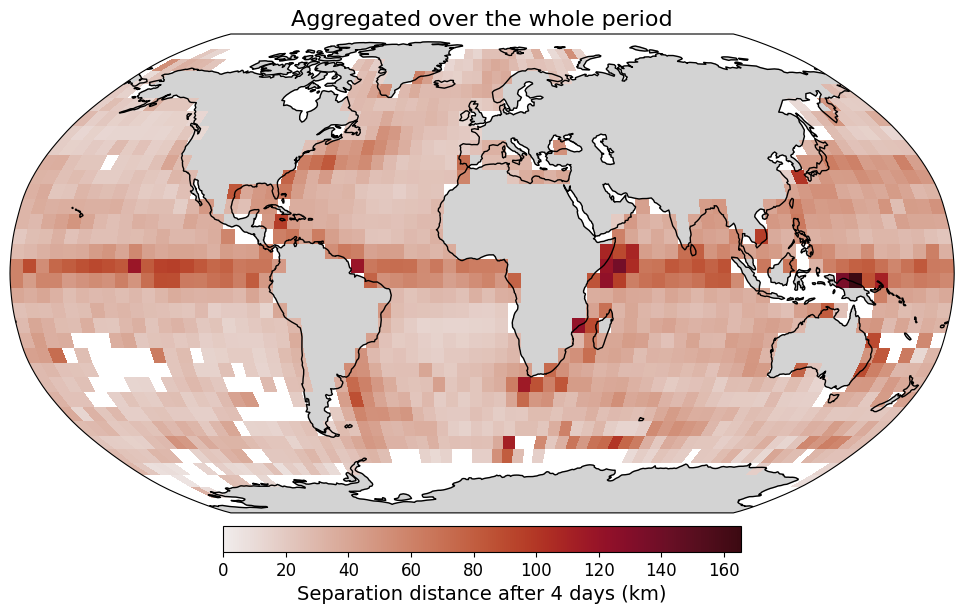

In [ ]:
fig, ax = plot_annual_mean_field(
    traj_errors_hist_ds.ensemble_separation_distance_lat_lon_4_mean * 1e-3,
    cmap=cmo.amp,
    vmin=0,
    vmax=None,
    label="Separation distance after 4 days (km)",
    title="Spatial binning using 70k 4-day trajectories"
)
plt.show()

/home/bertrava/.conda/envs/calibration/lib/python3.11/site-packages/dask/_task_spec.py:768: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


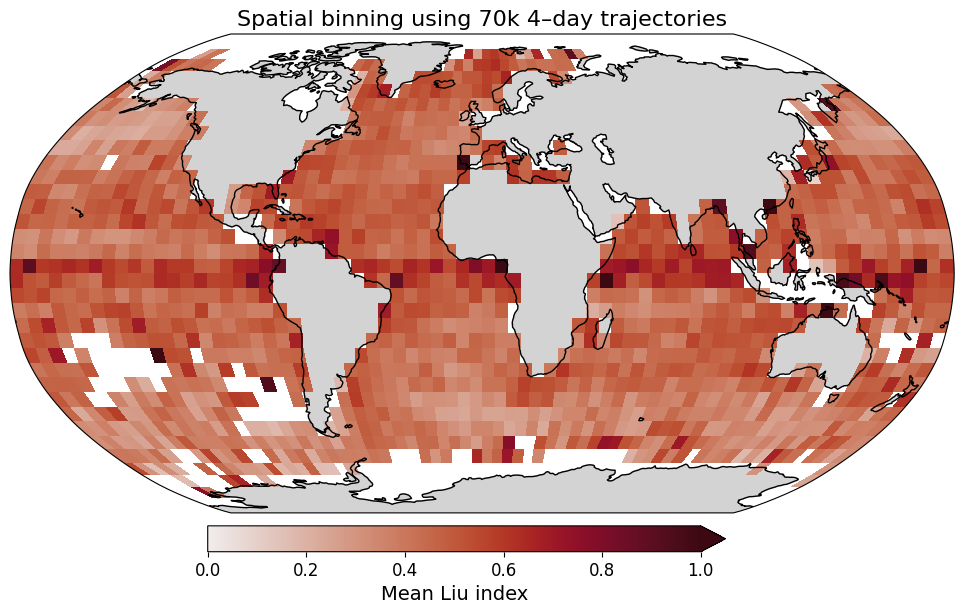

In [45]:
fig, ax = plot_annual_mean_field(
    traj_errors_hist_ds.ensemble_liu_index_lat_lon_4_mean,
    cmap=cmo.amp,
    vmin=0,
    vmax=1,
    label="Mean Liu index",
    title="Spatial binning using 70k 4–day trajectories",
    save_path=ROOT / "liu_index_4_days_mean.png",
)
plt.show()

/home/bertrava/.conda/envs/calibration/lib/python3.11/site-packages/dask/_task_spec.py:768: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


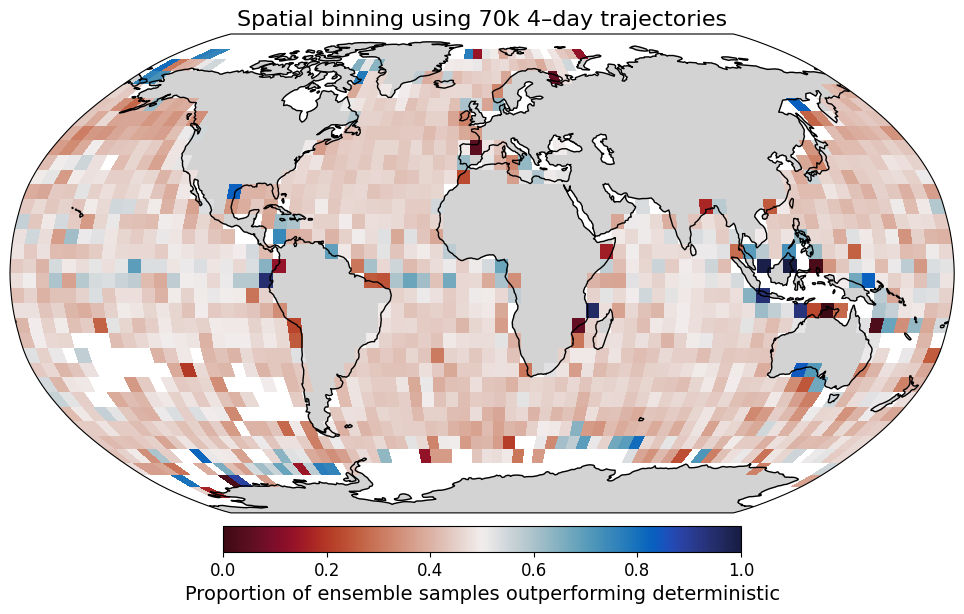

In [46]:
fig, ax = plot_annual_mean_field(
    traj_errors_hist_ds.ensemble_best_than_mean_in_separation_distance_lat_lon_4_mean,
    cmap=cmo.balance_r,
    vmin=0,
    vmax=1,
    label="Proportion of ensemble samples outperforming deterministic",
    title="Spatial binning using 70k 4–day trajectories",
    save_path=ROOT / "ensemble_better_than_mean_prop_4_days_mean.png",
)
plt.show()

In [34]:
duacs_ds = xr.open_zarr(
    DATA_DIR / f"cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_{from_datetime_str}_{to_datetime_str}.zarr"
)

In [35]:
no_eq_mask = np.abs(traj_errors_ds.reference_lat.isel(obs=0)) > 10
no_eq_idx = np.argwhere(no_eq_mask.values)

In [36]:
traj_errors_no_eq_ds = traj_errors_ds.isel(traj=no_eq_idx.ravel())

In [10]:
ex1 = int(
    traj_errors_no_eq_ds.ensemble_liu_index.sel(obs=np.timedelta64(6, "D")).min(dim="sample").argmin(dim="traj")
)

In [37]:
ex2 = int(
    traj_errors_no_eq_ds.ensemble_liu_index.sel(obs=np.timedelta64(6, "D")).max(dim="sample").argmin(dim="traj")
)

In [38]:
ex3 = int(
    traj_errors_no_eq_ds.ensemble_liu_index.sel(obs=np.timedelta64(6, "D")).mean(dim="sample").argmin(dim="traj")
)

In [39]:
ex4 = int(
    traj_errors_no_eq_ds.ensemble_best_than_mean_in_liu_index.sel(obs=np.timedelta64(6, "D")).argmax(dim="traj")
)

In [20]:
ex5 = int(
    traj_errors_no_eq_ds.ensemble_separation_distance.sel(obs=np.timedelta64(6, "D")).mean(dim="sample").argmax(dim="traj")
)

In [37]:
ex6 = int(
    (
        traj_errors_no_eq_ds.mean_separation_distance.sel(obs=np.timedelta64(6, "D")) -
        traj_errors_no_eq_ds.ensemble_separation_distance.sel(obs=np.timedelta64(6, "D")).max(dim="sample")
    ).argmax(dim="traj")
)

In [40]:
ex7 = int(
    (
        traj_errors_no_eq_ds.mean_separation_distance.sel(obs=np.timedelta64(6, "D")) -
        traj_errors_no_eq_ds.ensemble_separation_distance.sel(obs=np.timedelta64(6, "D")).min(dim="sample")
    ).argmax(dim="traj")
)

In [41]:
ex8 = int(
    (
        traj_errors_no_eq_ds.mean_separation_distance.sel(obs=np.timedelta64(6, "D")) -
        traj_errors_no_eq_ds.ensemble_separation_distance.sel(obs=np.timedelta64(6, "D")).mean(dim="sample")
    ).argmax(dim="traj")
)

In [21]:
# (np.datetime64('2009-09-04T01:00:00'),
#  array(19.74666, dtype=float32),
#  array(-25.36712, dtype=float32))

In [22]:
# (np.datetime64('2011-05-22T19:00:00'),
#  array(-20.05307, dtype=float32),
#  array(-85.64425, dtype=float32))

In [23]:
# (np.datetime64('2000-01-24T07:00:00'),
#  array(-3.07391, dtype=float32),
#  array(75.60208, dtype=float32))

In [57]:
def plot_trajectories(
    trajectories, horizon_day, background=True, animate=False, interval=100, title=None, save_path=None, dpi=300
):
    animated_lines = []
    animated_backgrounds = []
    
    def plot_trajectory(ds, traj_id, inset_pos, inset_connector_visible, scale_pos, add_text):
        ds = ds.isel(traj=traj_id).sel(
            obs=np.arange(
                np.timedelta64(0, "h"),
                np.timedelta64(horizon_day * 24, "h") + np.timedelta64(1, "h"), 
                np.timedelta64(1, "h")
            )
        )
        segs = np.stack([ds.simulated_ensemble_lon, ds.simulated_ensemble_lat], axis=-1)

        pad = .1
        lon_min = float(min(ds.reference_lon.min(), ds.simulated_mean_lon.min(), ds.simulated_ensemble_lon.min())) - pad
        lon_max = float(max(ds.reference_lon.max(), ds.simulated_mean_lon.max(), ds.simulated_ensemble_lon.max())) + pad
        lat_min = float(min(ds.reference_lat.min(), ds.simulated_mean_lat.min(), ds.simulated_ensemble_lat.min())) - pad
        lat_max = float(max(ds.reference_lat.max(), ds.simulated_mean_lat.max(), ds.simulated_ensemble_lat.max())) + pad

        inset_width = 0.35
        ax_inset = ax_global.inset_axes((*inset_pos, inset_width, inset_width), projection=ccrs.Robinson())
        ax_inset.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        inset_indicator = ax_global.indicate_inset_zoom(ax_inset, edgecolor="k", linewidth=1)
        for connector, visible in zip(inset_indicator.connectors, inset_connector_visible):
            connector.set(visible=visible)

        lon_min, lon_max, lat_min, lat_max = ax_inset.get_extent(crs=ccrs.PlateCarree())

        if background:
            add_background(ax_inset, ds, lon_min, lon_max, lat_min, lat_max)
        
        add_trajectories_static(ax_global, ds, segs)
        add_trajectories_animated(ax_inset, ds, segs)

        add_scale(ax_inset, scale_pos, lon_min, lon_max, lat_min, lat_max, add_text)
        
        ax_inset.coastlines()
        ax_inset.add_feature(cfeature.LAND, color="lightgrey")

    def add_background(ax_inset, ds, lon_min, lon_max, lat_min, lat_max):
        pad = .1
        ref_times = ds.reference_time.values
        
        speed_data = []
        for t in ref_times:
            u_da = duacs_ds.ugos.sel(
                time=t, method="nearest"
            ).sel(
                latitude=slice(lat_min - pad, lat_max + pad), 
                longitude=slice(lon_min - pad, lon_max + pad)
            )
            v_da = duacs_ds.vgos.sel(
                time=t, method="nearest"
            ).sel(
                latitude=slice(lat_min - pad, lat_max + pad), 
                longitude=slice(lon_min - pad, lon_max + pad)
            )
            da = np.sqrt(u_da**2 + v_da**2)
            speed_data.append(da.values)
        
        u_da = duacs_ds.ugos.sel(
            time=ref_times[0], method="nearest"
        ).sel(
            latitude=slice(lat_min - pad, lat_max + pad), 
            longitude=slice(lon_min - pad, lon_max + pad)
        )
        
        mesh = ax_inset.pcolormesh(
            u_da.longitude,
            u_da.latitude,
            speed_data[0],
            transform=ccrs.PlateCarree(),
            cmap=cmo.speed,
            vmin=0,
            vmax=1,
        )
        
        animated_backgrounds.append({
            "mesh": mesh,
            "speed_data": speed_data,
        })

    def add_trajectories_static(ax, ds, segs):
        ax.add_collection(
            LineCollection(segs, colors="lightgrey", linewidths=1, alpha=0.5, transform=ccrs.PlateCarree())
        )
        ax.plot(ds.simulated_mean_lon, ds.simulated_mean_lat, transform=ccrs.PlateCarree(), color="grey")
        ax.plot(ds.reference_lon, ds.reference_lat, transform=ccrs.PlateCarree(), color="k")

        ax.coastlines()
        ax.add_feature(cfeature.LAND, color="lightgrey")

    def add_trajectories_animated(ax, ds, segs):
        # ...existing code...
        n_samples = segs.shape[0]
        
        ensemble_lines = []
        for i in range(n_samples):
            line, = ax.plot([], [], color="lightgrey", linewidth=1, alpha=0.5, transform=ccrs.PlateCarree())
            ensemble_lines.append(line)
        
        mean_line, = ax.plot([], [], color="grey", transform=ccrs.PlateCarree())
        ref_line, = ax.plot([], [], color="k", transform=ccrs.PlateCarree())
        
        animated_lines.append({
            "ensemble_lines": ensemble_lines,
            "ensemble_lons": ds.simulated_ensemble_lon.values,
            "ensemble_lats": ds.simulated_ensemble_lat.values,
            "mean_line": mean_line,
            "mean_lon": ds.simulated_mean_lon.values,
            "mean_lat": ds.simulated_mean_lat.values,
            "ref_line": ref_line,
            "ref_lon": ds.reference_lon.values,
            "ref_lat": ds.reference_lat.values,
        })

    def add_scale(ax_inset, scale_pos, lon_min, lon_max, lat_min, lat_max, add_text):
        lat_pos, lon_pos = scale_pos.split(" ")
        latlon_pad = 0.05
        text_pad = 0.15
        if lat_pos == "upper":
            lat_start = lat_max
            lat_pad = -latlon_pad
            text_pad *= -1
            va = "bottom"
        else:
            lat_start = lat_min
            lat_pad = latlon_pad
            va = "top"
        if lon_pos == "right":
            lon_start = lon_max
            lon_pad = -latlon_pad * 2
            direction = -1
        else:
            lon_start = lon_min
            lon_pad = latlon_pad
            direction = 1

        lat0 = lat_start + lat_pad * (lat_max - lat_min)
        lon0 = lon_start + lon_pad * (lon_max - lon_min)

        distance_km = 50
        distance_m = direction * distance_km * 1000

        geo = Geodesic()
        end = geo.direct((lon0, lat0), azimuths=90, distances=distance_m)
        lon1, lat1 = end[0, 0], end[0, 1]

        ax_inset.plot(
            [lon0, lon1],
            [lat0, lat1],
            transform=ccrs.PlateCarree(),
            color="k",
            linewidth=1,
            linestyle="--"
        )
        
        if add_text:
            ax_inset.text(
                (lon0 + lon1) / 2,
                lat0 + text_pad * (lat_max - lat_min),
                f"{distance_km} km",
                transform=ccrs.PlateCarree(),
                ha="center",
                va=va,
                fontsize=FONTSIZE_TICK,
            )

    def update_frame(frame):
        """Update all animated elements for a given frame."""
        for traj_data in animated_lines:
            for i, line in enumerate(traj_data["ensemble_lines"]):
                line.set_data(traj_data["ensemble_lons"][i, :frame+1], traj_data["ensemble_lats"][i, :frame+1])
            traj_data["mean_line"].set_data(traj_data["mean_lon"][:frame+1], traj_data["mean_lat"][:frame+1])
            traj_data["ref_line"].set_data(traj_data["ref_lon"][:frame+1], traj_data["ref_lat"][:frame+1])
        for bg_data in animated_backgrounds:
            bg_data["mesh"].set_array(bg_data["speed_data"][frame].ravel())

    def save_frames(save_path, n_obs, dpi):
        """Save each frame as an individual PNG file."""
        save_path = Path(save_path)
        frames_dir = save_path.parent / save_path.stem
        frames_dir.mkdir(parents=True, exist_ok=True)
        
        n_digits = len(str(n_obs - 1))
        
        for frame in range(n_obs):
            update_frame(frame)
            frame_path = frames_dir / f"{str(frame).zfill(n_digits)}.png"
            fig.savefig(
                frame_path,
                dpi=dpi,
                bbox_inches="tight",
                pad_inches=0.1,
                facecolor=fig.get_facecolor(),
                edgecolor="none",
            )
        
        print(f"Saved {n_obs} frames to {frames_dir}")

    fig = plt.figure(figsize=(12, 6))

    ax_global = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
    ax_global.set_global()

    ax_global.set_title(title or f"{horizon_day}–day trajectory simulation", fontsize=FONTSIZE_TITLE)

    legend_elements = [
        Line2D([0], [0], color="k", lw=2, label="Reference"),
        Line2D([0], [0], color="lightgrey", lw=2, label="Simulated ensemble"),
        Line2D([0], [0], color="grey", lw=2, label="Deterministic simulation"),
    ]
    ax_global.legend(
        handles=legend_elements,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.005),
        ncol=len(legend_elements),
        frameon=False,  
        fontsize=FONTSIZE_LEGEND
    )

    for trajectory in trajectories:
        plot_trajectory(*trajectory)

    n_obs = horizon_day * 24 + 1

    if not animate:
        update_frame(n_obs - 1)
        save_figure(fig, save_path, dpi=dpi)
        return fig, None

    if save_path is not None:
        save_frames(save_path, n_obs, dpi)

    def init():
        all_artists = []
        for traj_data in animated_lines:
            for line in traj_data["ensemble_lines"]:
                line.set_data([], [])
                all_artists.append(line)
            traj_data["mean_line"].set_data([], [])
            traj_data["ref_line"].set_data([], [])
            all_artists.append(traj_data["mean_line"])
            all_artists.append(traj_data["ref_line"])
        for bg_data in animated_backgrounds:
            all_artists.append(bg_data["mesh"])
        return all_artists

    def update(frame):
        all_artists = []
        for traj_data in animated_lines:
            for i, line in enumerate(traj_data["ensemble_lines"]):
                line.set_data(traj_data["ensemble_lons"][i, :frame+1], traj_data["ensemble_lats"][i, :frame+1])
                all_artists.append(line)
            traj_data["mean_line"].set_data(traj_data["mean_lon"][:frame+1], traj_data["mean_lat"][:frame+1])
            traj_data["ref_line"].set_data(traj_data["ref_lon"][:frame+1], traj_data["ref_lat"][:frame+1])
            all_artists.append(traj_data["mean_line"])
            all_artists.append(traj_data["ref_line"])
        for bg_data in animated_backgrounds:
            bg_data["mesh"].set_array(bg_data["speed_data"][frame].ravel())
            all_artists.append(bg_data["mesh"])
        return all_artists

    anim = animation.FuncAnimation(
        fig, update, init_func=init, frames=n_obs, interval=interval, blit=True, repeat=True
    )

    return fig, anim

In [43]:
trajectories = (
    (traj_errors_no_eq_ds, ex8, (0.25, 0.25), (False, False, True, True), "upper left", False),
    (traj_errors_ds, ex2, (0, 0.6), (False, False, True, True), "upper left", False),
    (traj_errors_ds, ex3, (-0.01, 0.03), (False, True, False, True), "bottom right", True),
    (traj_errors_ds, ex4, (0.55, 0.6), (True, True, False, False), "upper left", False),
    (traj_errors_no_eq_ds, ex7, (0.59, 0.03), (True, True, False, False), "bottom right", False)
)

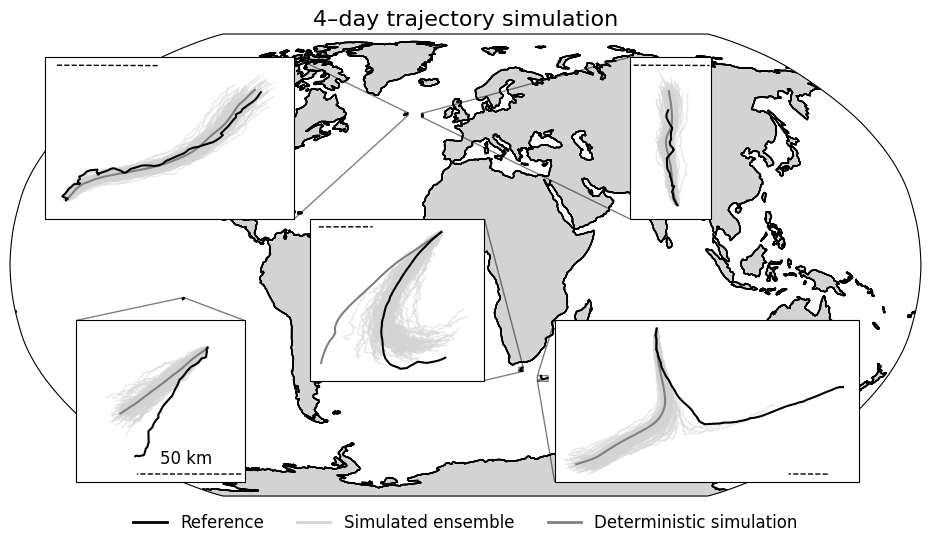

In [58]:
fig, anim = plot_trajectories(trajectories, horizon_day=4, background=False, animate=False)
plt.show()

Saved 97 frames to trajectory_simulation_4_days


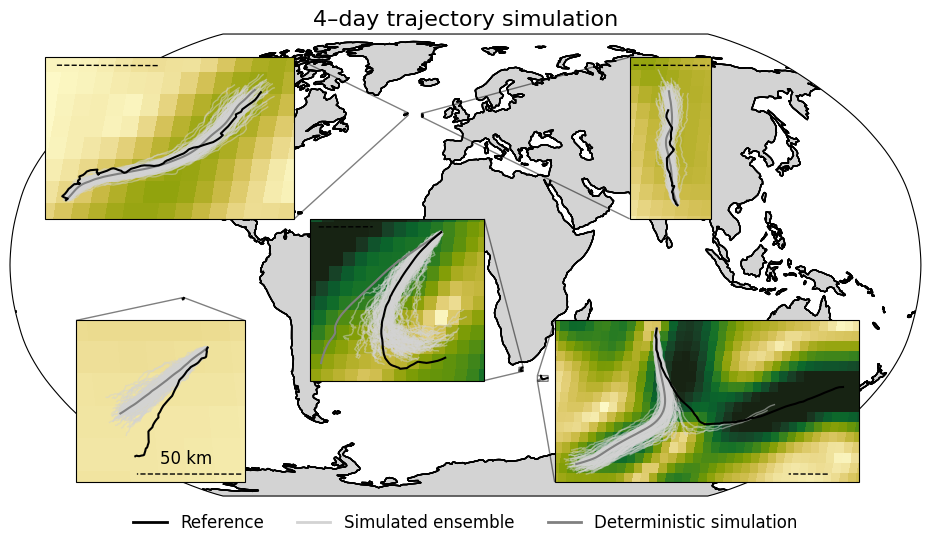

In [59]:
fig, anim = plot_trajectories(
    trajectories, horizon_day=4, animate=True, save_path=ROOT / "trajectory_simulation_4_days.mp4"
)
HTML(anim.to_html5_video())